In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

In [3]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv('online_retail_final.csv/online_retail_final.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [6]:
df.shape

(392735, 9)

In [7]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,TotalPrice
count,392735.000000,392735.000000,392735.000000,392735.000000,392735.000000
mean,560624.318859,10.242645,2.787111,15300.835136,18.246537
std,13113.076784,16.172009,2.704759,1709.095993,32.558080
min,536365.000000,1.000000,0.120000,12347.000000,0.120000
25%,549233.000000,2.000000,1.250000,13975.000000,4.680000
50%,561894.000000,5.000000,1.950000,15159.000000,11.700000
75%,572103.000000,12.000000,3.750000,16800.000000,19.500000
max,581587.000000,147.000000,19.960000,18287.000000,1914.240000


In [8]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalPrice     float64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392735 entries, 0 to 392734
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392735 non-null  int64  
 1   StockCode    392735 non-null  object 
 2   Description  392735 non-null  object 
 3   Quantity     392735 non-null  int64  
 4   InvoiceDate  392735 non-null  object 
 5   UnitPrice    392735 non-null  float64
 6   CustomerID   392735 non-null  float64
 7   Country      392735 non-null  object 
 8   TotalPrice   392735 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 27.0+ MB


In [10]:
df.loc[:,'InvoiceDate'] = pd.to_datetime(df.loc[:,'InvoiceDate'])

In [11]:
df.set_index("InvoiceDate",inplace=True)

In [12]:
df


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,pack of 20 spaceboy napkins,12,0.85,12680.0,France,10.20
2011-12-09 12:50:00,581587,22899,children's apron dolly girl,6,2.10,12680.0,France,12.60
2011-12-09 12:50:00,581587,23254,childrens cutlery dolly girl,4,4.15,12680.0,France,16.60


In [13]:
des = pd.DataFrame(df.groupby('Description').Quantity.sum())
des = des.iloc[:,-1]
des


Description
 4 purple flock dinner candles       140
 50's christmas gift bag large      1485
 dolly girl beaker                   998
 i love london mini backpack         360
 i love london mini rucksack           1
                                    ... 
zinc t-light holder stars small     4678
zinc top  2 door wooden shelf         10
zinc willie winkie  candle stick    2415
zinc wire kitchen organiser           25
zinc wire sweetheart letter tray      80
Name: Quantity, Length: 3837, dtype: int64

In [14]:
des = pd.DataFrame(des,index=None)
des

,Quantity
Description,
4 purple flock dinner candles,140
50's christmas gift bag large,1485
dolly girl beaker,998
i love london mini backpack,360
i love london mini rucksack,1
...,...
zinc t-light holder stars small,4678
zinc top 2 door wooden shelf,10
zinc willie winkie candle stick,2415


In [15]:
des.reset_index(inplace=True)

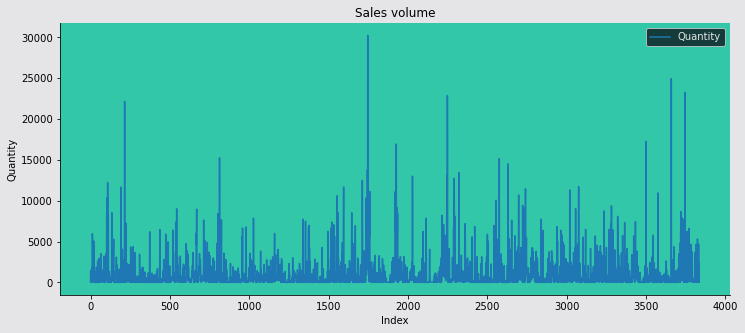

In [16]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e7" )
ax.set_facecolor("#32c7a9")

des.plot(ax = ax).set_title("Sales volume")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
ax.set_xlabel("Index")
ax.set_ylabel("Quantity")

sns.despine()

plt.savefig('sales_volume.png',bbox_inches='tight')

plt.show()


In [17]:
des1 = des.copy()

In [18]:
des1 = des.loc[des['Quantity'].idxmax()]

In [19]:
des1

Description    jumbo bag red retrospot
Quantity                         30251
Name: 1747, dtype: object

In [20]:
prices = pd.DataFrame(df.groupby('InvoiceDate').TotalPrice.sum())
prices = prices.iloc[:,-1]
prices 

InvoiceDate
2010-12-01 08:26:00    139.12
2010-12-01 08:28:00     22.20
2010-12-01 08:34:00    348.78
2010-12-01 08:35:00     17.85
2010-12-01 08:45:00    801.86
                        ...  
2011-12-09 12:23:00    124.60
2011-12-09 12:25:00    140.64
2011-12-09 12:31:00    329.05
2011-12-09 12:49:00    339.20
2011-12-09 12:50:00    249.45
Name: TotalPrice, Length: 16859, dtype: float64

In [21]:
prices = pd.DataFrame(prices)
prices

,TotalPrice
InvoiceDate,
2010-12-01 08:26:00,139.12
2010-12-01 08:28:00,22.20
2010-12-01 08:34:00,348.78
2010-12-01 08:35:00,17.85
2010-12-01 08:45:00,801.86
...,...
2011-12-09 12:23:00,124.60
2011-12-09 12:25:00,140.64
2011-12-09 12:31:00,329.05


In [22]:
prices_weekly = prices.resample('W').sum()
prices_weekly.head()

,TotalPrice
InvoiceDate,
2010-12-05,132095.20
2010-12-12,165846.59
2010-12-19,140098.84
2010-12-26,38960.64
2011-01-02,0.00


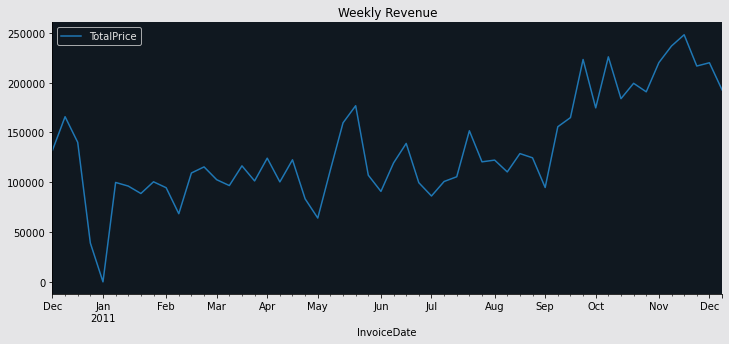

In [23]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e7" )
ax.set_facecolor("#101820")

prices_weekly.plot(ax = ax).set_title("Weekly Revenue")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.savefig('Weekly_Revenue.png')
plt.show()


No handles with labels found to put in legend.


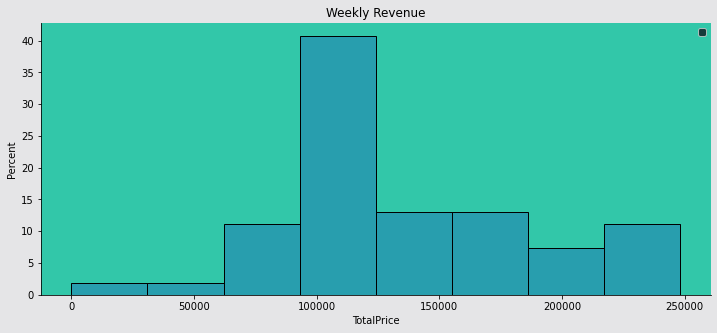

In [24]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e7" )
ax.set_facecolor("#32c7a9")

sns.histplot(prices_weekly,ax = ax,stat='percent').set_title("Weekly Revenue")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
ax.set_xlabel("TotalPrice")

sns.despine()
plt.savefig('Weekly_Revenue1.png')
plt.show()


From the revenue per week graph we can interpret that:
   
    1)The online retail was close on January.
    
    2)It had its first peak on mid of May.
    
    3)2nd peak on October.
    
    4)Highest sales in mid of November.

In [25]:
prices_daily = prices.resample('D').sum()
prices_daily.head()

,TotalPrice
InvoiceDate,
2010-12-01,38668.66
2010-12-02,40858.83
2010-12-03,22428.26
2010-12-04,0.00
2010-12-05,30139.45


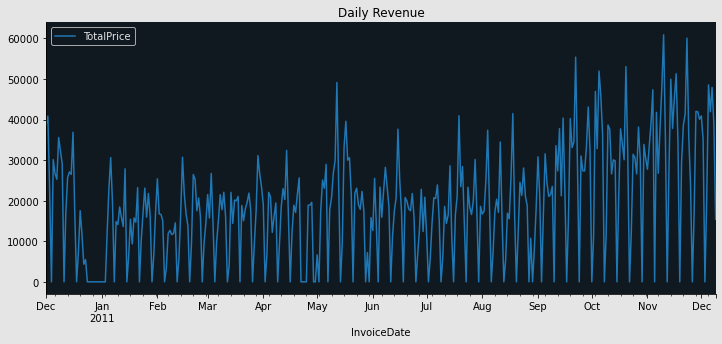

In [26]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e5" )
ax.set_facecolor("#101820")

prices_daily.plot(ax = ax).set_title("Daily Revenue")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.savefig('Daily_Revenue.png')
plt.show()


There is 0 revenue in January

No handles with labels found to put in legend.


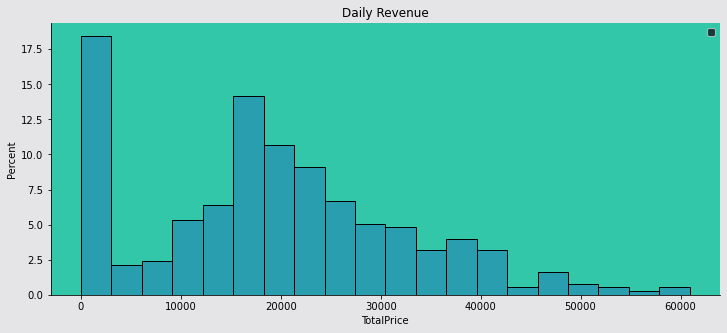

In [27]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e7" )
ax.set_facecolor("#32c7a9")

sns.histplot(prices_daily,ax = ax,stat='percent',bins=20).set_title("Daily Revenue")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
ax.set_xlabel("TotalPrice")

sns.despine()
plt.savefig('Daily_Revenue1.png')
plt.show()


Most daily transaction about 17.5% is between 0-5000

In [28]:
prices_daily.loc["2010-12-23" : "2011-1-4"]

,TotalPrice
InvoiceDate,
2010-12-23,5469.37
2010-12-24,0.00
2010-12-25,0.00
2010-12-26,0.00
2010-12-27,0.00
2010-12-28,0.00
2010-12-29,0.00
2010-12-30,0.00
2010-12-31,0.00


In [29]:
prices_daily.reset_index(inplace = True)
prices_daily["Closed"] = np.where((prices_daily.TotalPrice == 0), 1, 0)
prices_daily.set_index("InvoiceDate", inplace = True)

In [30]:
prices_daily["weekday"] = prices_daily.index.day_name()
prices_daily

,TotalPrice,Closed,weekday
InvoiceDate,,,
2010-12-01,38668.66,0,Wednesday
2010-12-02,40858.83,0,Thursday
2010-12-03,22428.26,0,Friday
2010-12-04,0.00,1,Saturday
2010-12-05,30139.45,0,Sunday
...,...,...,...
2011-12-05,48575.30,0,Monday
2011-12-06,41944.83,0,Tuesday
2011-12-07,47935.39,0,Wednesday


In [31]:
prices_daily[prices_daily.TotalPrice == 0].weekday.value_counts()

Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: weekday, dtype: int64

Retailer should be closed on Saturdays.

In [32]:
prices_daily.groupby("weekday").TotalPrice.sum()

weekday
Friday       1081523.06
Monday       1141983.81
Saturday           0.00
Sunday        744684.22
Thursday     1583224.26
Tuesday      1272165.29
Wednesday    1342472.89
Name: TotalPrice, dtype: float64

In [33]:
daily_sales_workdays = prices_daily[prices_daily.TotalPrice > 0].copy()
prices_daily.drop("weekday", axis = 1, inplace = True)
daily_sales_workdays.drop("weekday", axis = 1, inplace = True)

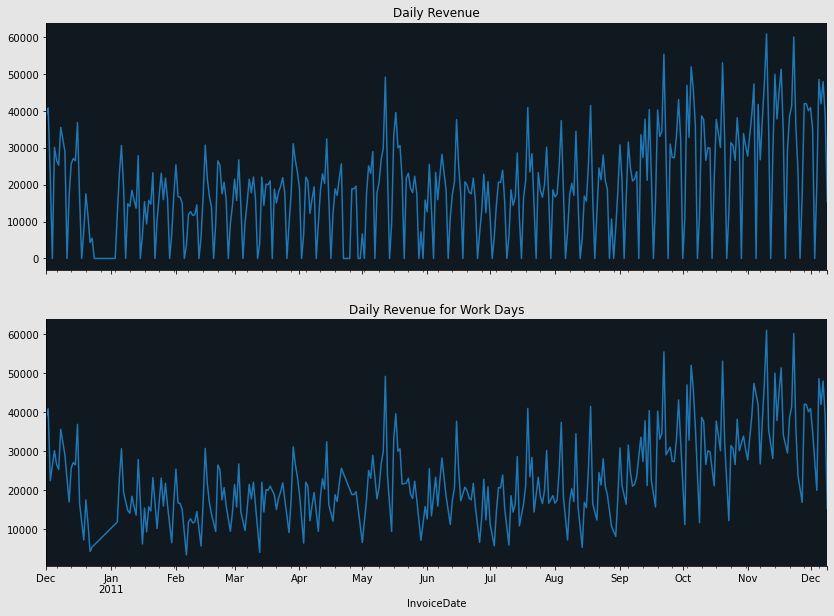

In [34]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

prices_daily.TotalPrice.plot(ax = axes[0]).set_title("Daily Revenue")
daily_sales_workdays.TotalPrice.plot(ax = axes[1]).set_title("Daily Revenue for Work Days")

sns.despine()
plt.savefig('daily.png')
plt.show()



We have increasing trend for the end of the year

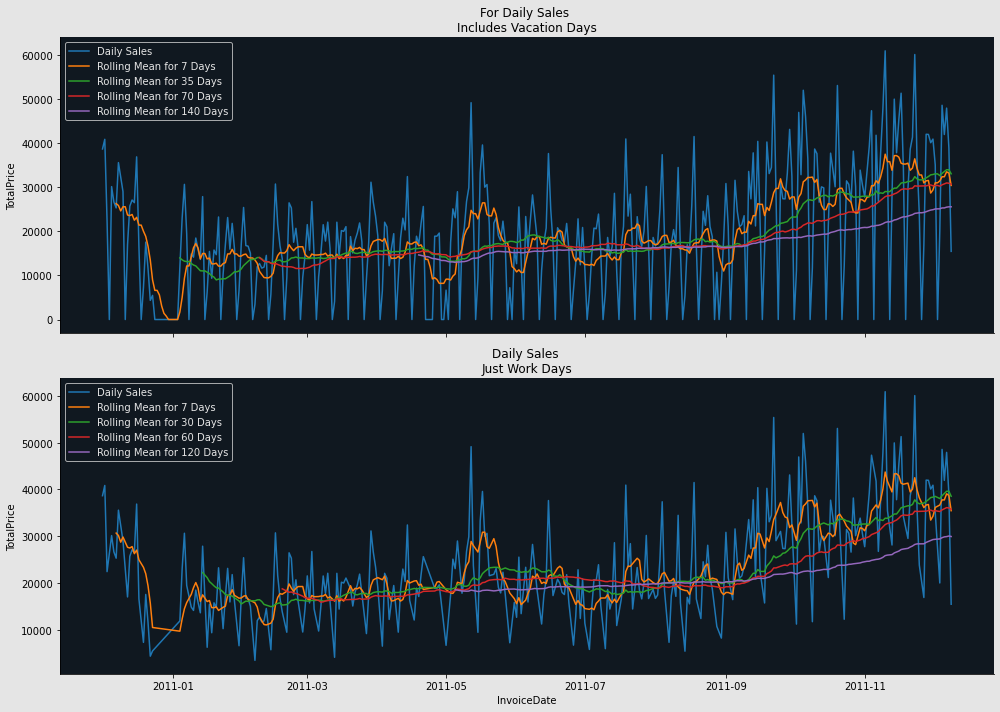

In [35]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
    
sns.lineplot(x = prices_daily.index, y = prices_daily.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("For Daily Sales \nIncludes Vacation Days")

sns.lineplot(x = prices_daily.index, y = prices_daily.TotalPrice.rolling(7).mean(), 
             ax = axes[0], label = "Rolling Mean for 7 Days")
sns.lineplot(x = prices_daily.index, y = prices_daily.TotalPrice.rolling(35).mean(), 
             ax = axes[0], label = "Rolling Mean for 35 Days")
sns.lineplot(x = prices_daily.index, y = prices_daily.TotalPrice.rolling(70).mean(), 
             ax = axes[0], label = "Rolling Mean for 70 Days")
sns.lineplot(x = prices_daily.index, y = prices_daily.TotalPrice.rolling(140).mean(), 
             ax = axes[0], label = "Rolling Mean for 140 Days")


sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[1], label = "Daily Sales").set_title("Daily Sales \nJust Work Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(6).mean(), 
             ax = axes[1], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(30).mean(),
             ax = axes[1], label = "Rolling Mean for 30 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean for 60 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(120).mean(), 
             ax = axes[1], label = "Rolling Mean for 120 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
    
sns.despine()
plt.tight_layout()
plt.savefig('daily_sales2.png')
plt.show()


In [36]:
def check_adf(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {adf[0]}")
    pvalue = adf[1]; print(f"p-value: {adf[1]}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [37]:
print("Performing Augmented Dickey-Fuller test for Total Price \n")

check_adf(prices_daily.TotalPrice)

print("\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n")

check_adf(daily_sales_workdays.TotalPrice)

Performing Augmented Dickey-Fuller test for Total Price 

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.97497494903486
p-value: 0.297652338253093
Number of lags: 13

Critical Values : 

	 1% 	 -3.448645946352023
	 5% 	 -2.869602139060357
	 10% 	 -2.5710650077160495

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.4618619657326275
p-value: 0.5522863148922865
Number of lags: 13

Critical Values : 

	 1% 	 -3.4530232710482367
	 5% 	 -2.871523926671883
	 10% 	 -2.5720897694878424

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.


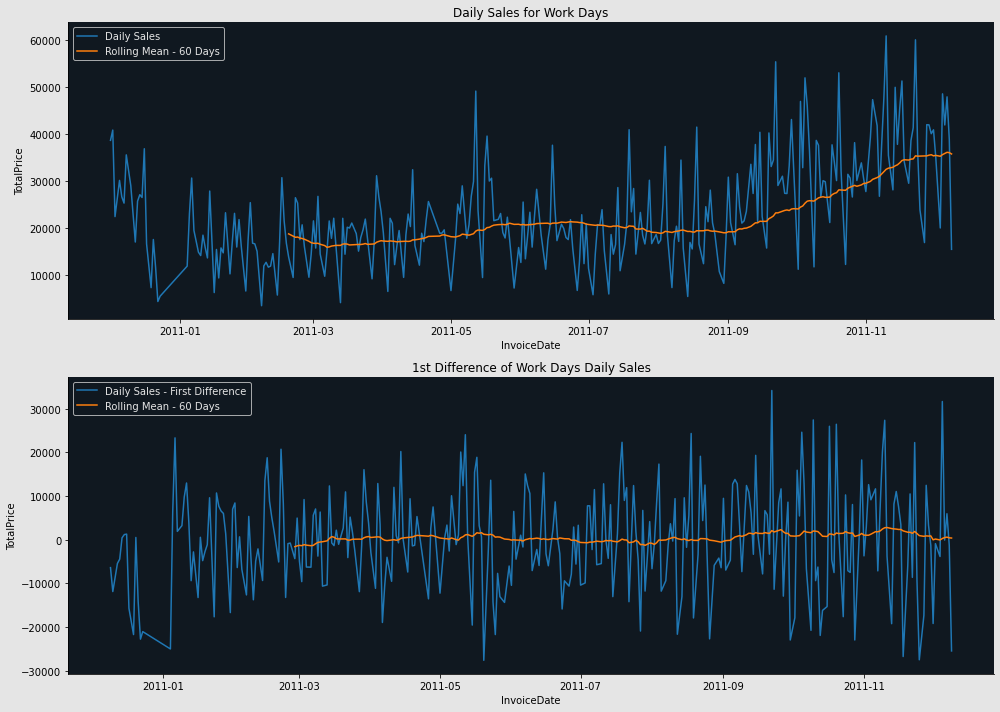

In [38]:
fig, axes = plt.subplots(2, 1, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("Daily Sales for Work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[0], label = "Rolling Mean - 60 Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7), 
             ax = axes[1], label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7).rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean - 60 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()

plt.savefig('difference.png')

plt.show()


In [39]:
print("Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)")
check_adf(prices_daily["TotalPrice"].diff(7).dropna())

print("\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales")
check_adf(daily_sales_workdays["TotalPrice"].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -6.759454698100047
p-value: 2.8164503688265996e-09
Number of lags: 13

Critical Values : 

	 1% 	 -3.4490114443793214
	 5% 	 -2.8697627072503757
	 10% 	 -2.5711506161673716

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -6.182837977922007
p-value: 6.393301142728482e-08
Number of lags: 11

Critical Values : 

	 1% 	 -3.453342167806272
	 5% 	 -2.871663828287282
	 10% 	 -2.572164381381345

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.


In [40]:
decompose = seasonal_decompose(prices_daily["TotalPrice"], period = 7)

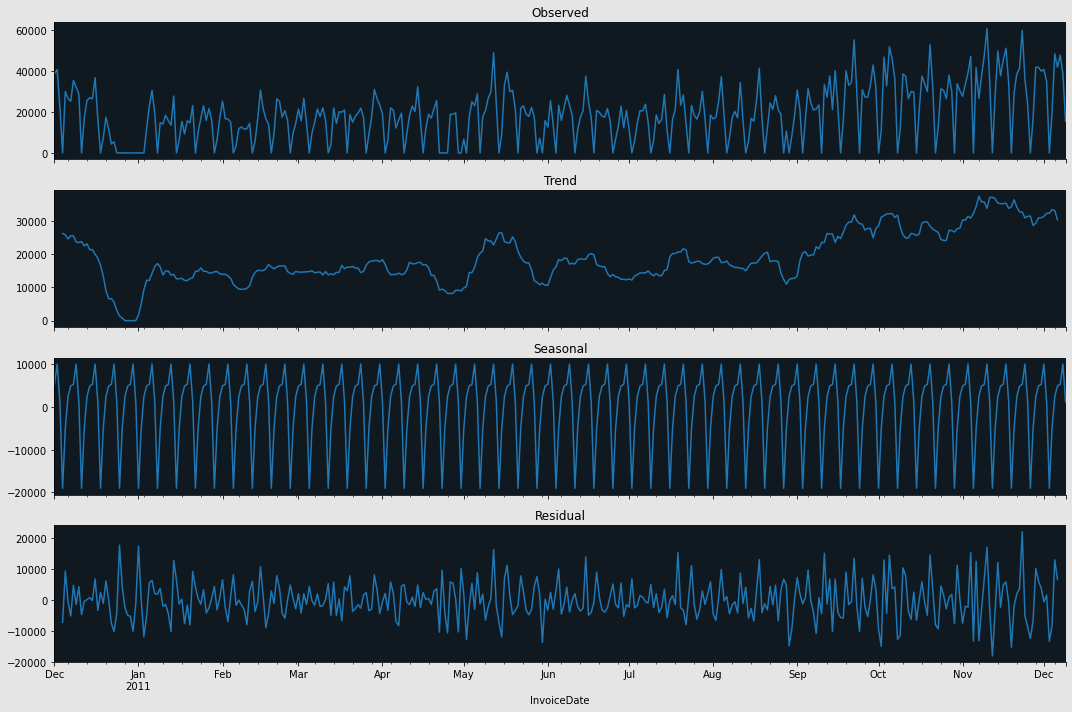

In [41]:
fig, axes = plt.subplots(4, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

decompose.observed.plot(ax = axes[0]).set_title("Observed")
decompose.trend.plot(ax = axes[1]).set_title("Trend")
decompose.seasonal.plot(ax = axes[2]).set_title("Seasonal")
decompose.resid.plot(ax = axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.savefig('Residual.png')

plt.show()


In [42]:
import statsmodels.api as sm
import warnings

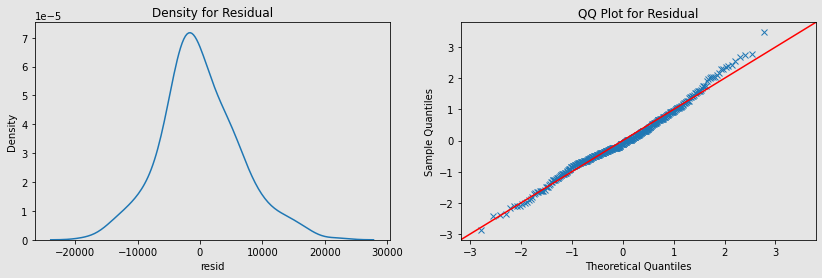

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density for Residual")

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    
    sm.qqplot(decompose.resid.dropna(), ax = axes[1], marker = "x", line = "45", fit = True)
    axes[1].set_title("QQ Plot for Residual")
plt.savefig('Density.png')
    
plt.show()


C:\Users\suraj\anaconda3\envs\ecommerce\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


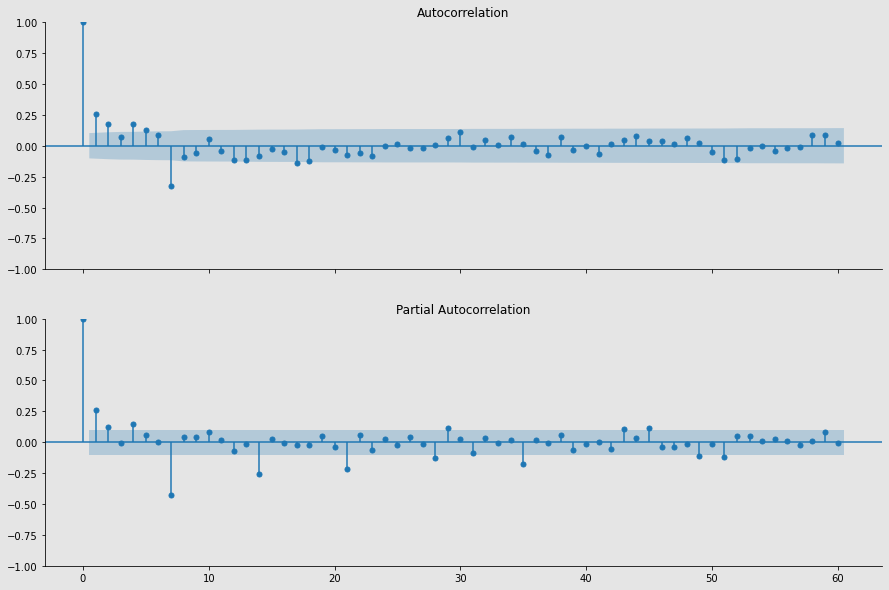

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
plot_acf(prices_daily["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[0])
plot_pacf(prices_daily["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[1])

sns.despine()

plt.savefig('Autocorrelation.png')
plt.show()


In [45]:
daily_data = prices_daily[["TotalPrice"]].dropna().reset_index()

daily_data.columns = ["ds", "y"]

train_size = int(0.85 * len(daily_data))

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(train)} \nValidation Days:\t {len(val)}")

Training Days:		317 
Validation Days:	 57


In [46]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

In [47]:
from fbprophet import Prophet

model = Prophet()

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.5639130996115719
MSE: 59407399.50198568
Correlation: 0.7510257429919313

For Validation set: 

R2: 0.5419831766555122
MSE: 115732041.80082722
Correlation: 0.8596096428173183


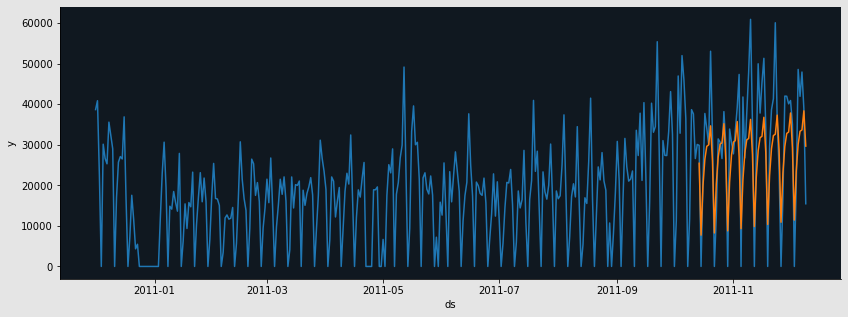

In [49]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax)

sns.despine()

plt.savefig('prediction.png')
plt.show()


In [50]:
black_friday = pd.DataFrame(
    {
        "holiday": "black friday",
        "ds": pd.to_datetime(["2011-11-24", "2012-11-23", "2013-11-22"]),
        "lower_window": 0,
        "upper_window": 1
    }
)

In [51]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

In [52]:
val

,ds,y,is_saturday
317,2011-10-14,29852.40,False
318,2011-10-15,0.00,True
319,2011-10-16,21160.87,False
320,2011-10-17,37719.53,False
321,2011-10-18,34067.67,False
322,2011-10-19,30099.56,False
323,2011-10-20,53061.41,False
324,2011-10-21,32210.03,False
325,2011-10-22,0.00,True
326,2011-10-23,12238.78,False


In [53]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [54]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.7286261006161754
MSE: 36968818.92289542
Correlation: 0.8537017274709698

For Validation set: 

R2: 0.5136970810017323
MSE: 122879394.1200744
Correlation: 0.8297469961380592


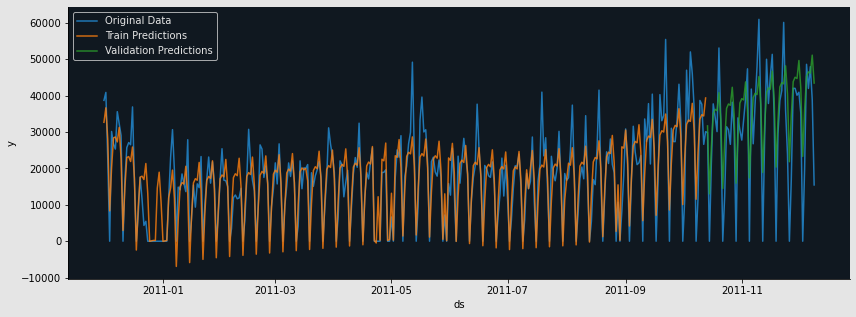

In [55]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()

plt.savefig('prediction2.png')
plt.show()


In [56]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
val_pred["yhat"] = np.where((val_pred.is_saturday == 0), val_pred.yhat, 0)

print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.7458534620919863
MSE: 34621963.87027395
Correlation: 0.8643112216761973

For Validation set: 

R2: 0.7028742317443533
MSE: 75077966.7453437
Correlation: 0.8585158123805817


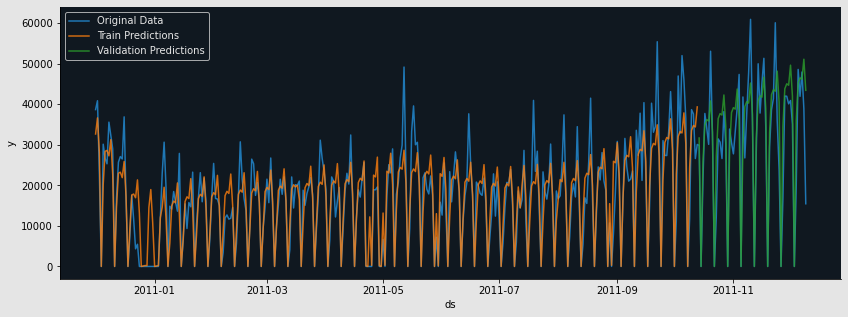

In [57]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()

plt.savefig('prediction3.png')
plt.show()


In [58]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

In [59]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)
future.tail()

,ds,is_saturday
734,2012-12-04,False
735,2012-12-05,False
736,2012-12-06,False
737,2012-12-07,False
738,2012-12-08,True


In [60]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
734,2012-12-04,38866.958479,30835.198305,46934.596526
735,2012-12-05,38462.475224,30397.429057,47026.170680
736,2012-12-06,42347.006792,34273.421714,50089.920303
737,2012-12-07,32730.574090,24672.595440,40606.199208
738,2012-12-08,10461.985463,2228.063450,18509.239662


In [61]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,34106.663940,27927.712018,43982.947693,34106.663940,34106.663940,0.0,0.0,0.0,0.0,...,4694.286822,4694.286822,4694.286822,12374.067096,12374.067096,12374.067096,0.0,0.0,0.0,35579.992426
1,2010-12-02,34104.914564,32214.073508,46994.512820,34104.914564,34104.914564,0.0,0.0,0.0,0.0,...,9428.787766,9428.787766,9428.787766,11873.645007,11873.645007,11873.645007,0.0,0.0,0.0,39812.321903
2,2010-12-03,34103.165187,22633.381881,38864.035377,34103.165187,34103.165187,0.0,0.0,0.0,0.0,...,744.542508,744.542508,744.542508,11299.137377,11299.137377,11299.137377,0.0,0.0,0.0,30551.819640
3,2010-12-04,34101.415811,164.722331,16596.523045,34101.415811,34101.415811,0.0,0.0,0.0,0.0,...,-16928.296634,-16928.296634,-16928.296634,10646.441104,10646.441104,10646.441104,0.0,0.0,0.0,8640.663388
4,2010-12-05,34099.666434,14470.904471,30901.245486,34099.666434,34099.666434,0.0,0.0,0.0,0.0,...,-5914.520407,-5914.520407,-5914.520407,9912.594775,9912.594775,9912.594775,0.0,0.0,0.0,22502.715369


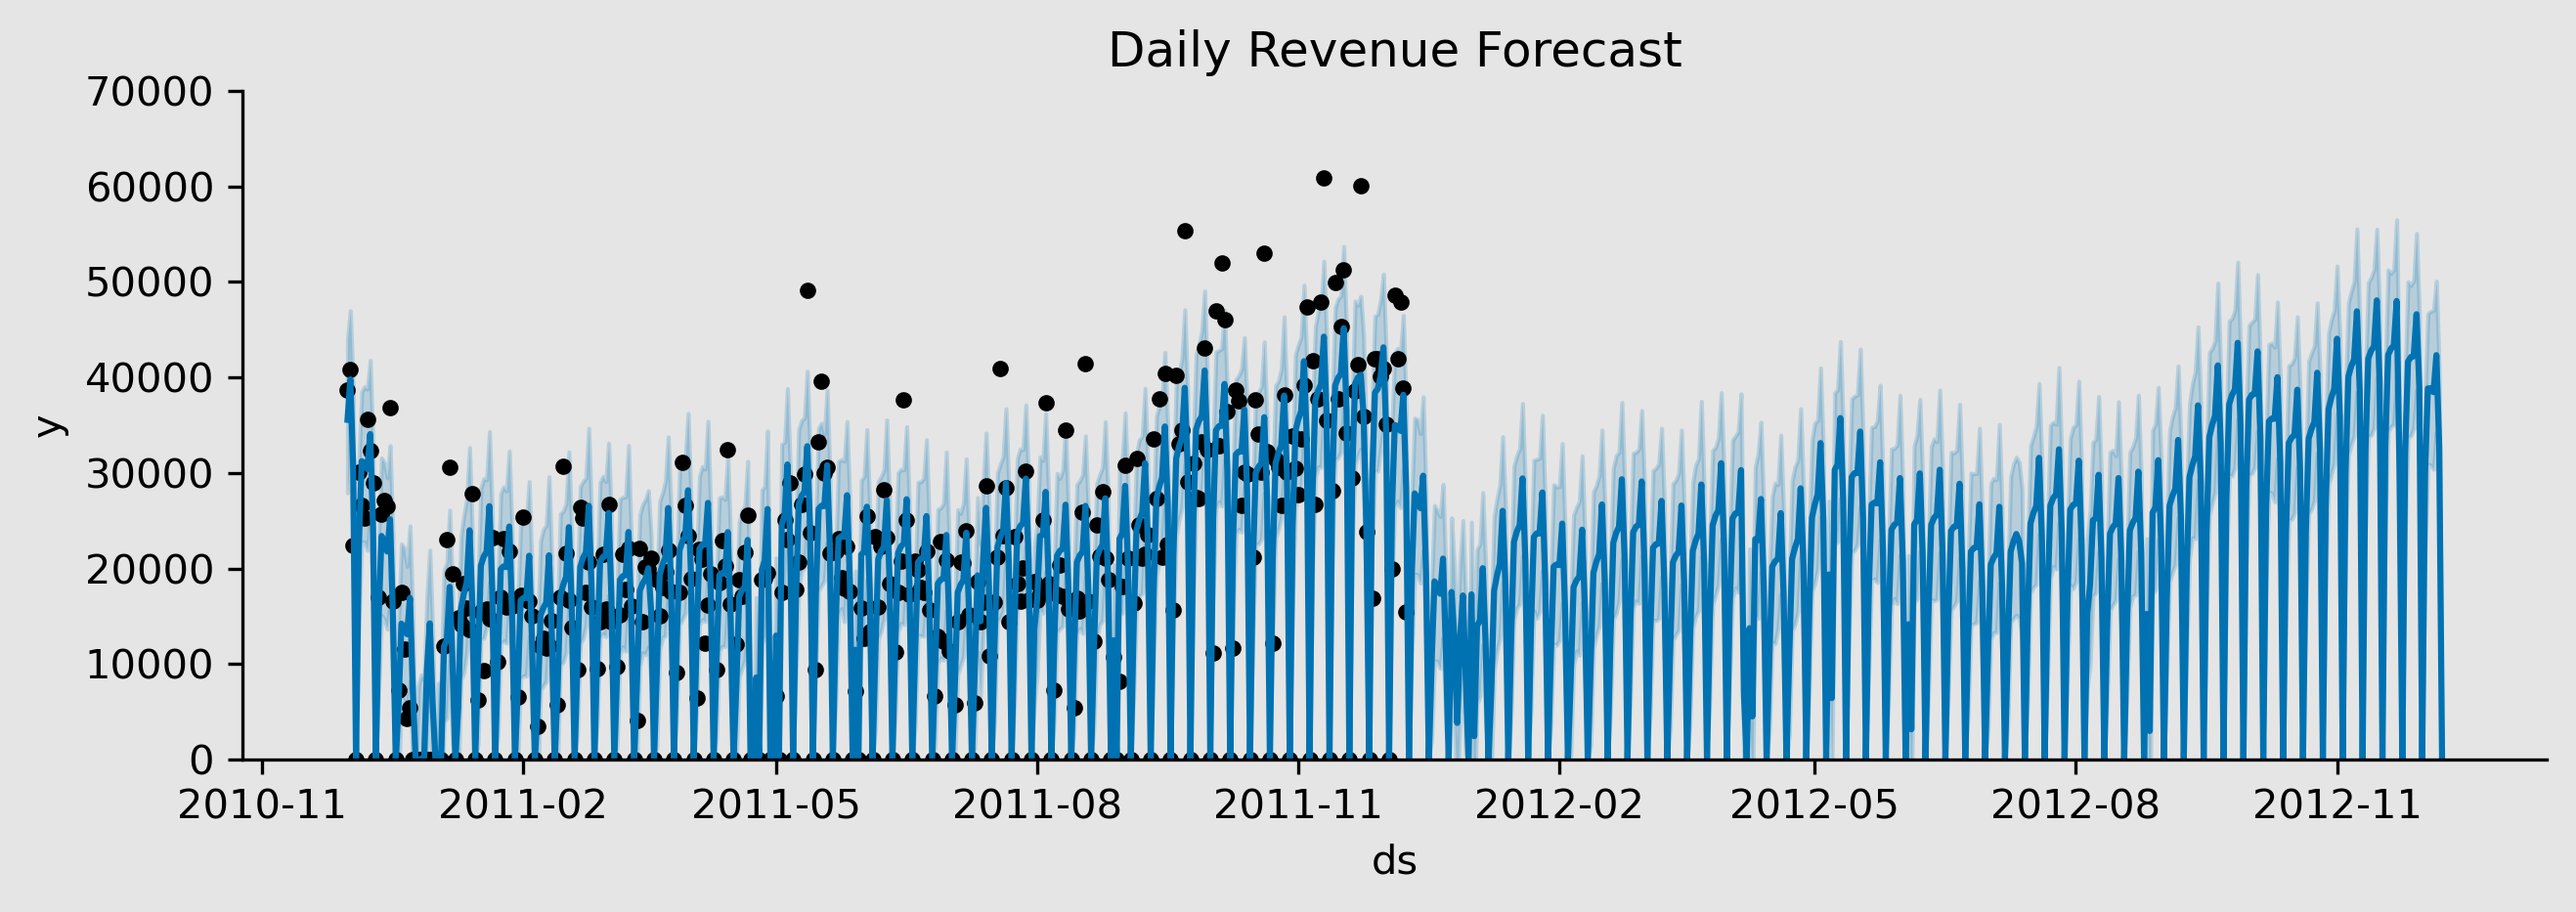

In [62]:
forecast["yhat"] = np.where((forecast.is_saturday == 0), forecast.yhat, 0)
forecast["yhat_lower"] = np.where((forecast.is_saturday == 0), forecast.yhat_lower, 0)
forecast["yhat_upper"] = np.where((forecast.is_saturday == 0), forecast.yhat_upper, 0)

fig, ax = plt.subplots(figsize = (9, 3), facecolor = "#e5e5e5", dpi = 300)

model.plot(forecast, ax = ax)

ax.set_title("Daily Revenue Forecast")
ax.grid(False)
ax.set_facecolor("#e5e5e5")
ax.set_ylim(0, 70000)

sns.despine()

plt.savefig('Future.png')
plt.show()
